In [ ]:
import Pkg; Pkg.add(["Plots", "Interpolations", "DataFrames", "CSV"]);
Pkg.update();
using Plots, Interpolations, DataFrames, CSV;

## Problem

Obtain sugar concentration vs time in cooling cup of coffee.

## Necessary quantities

Dynamics are governed by equations:

$$
\frac{dm}{dt} = A(m) \frac{D(T)}{d} (C_s(T) - C_b(m))
$$

$$
% \frac{dT}{dt} = f(T, V_w, V_m, T_{0w}, T_{0m})
\frac{dT}{dt} = -k(T - T_f)
$$

With:

- $D(T)$ - diffusion coefficient, depended on temperature
- $C_s(T)$ - maximum solubility of sugar at given temperature
- $C_b(m)$ - current sugar concentration
- $A(m)$ - surface area of dissolving substance
- $V_w$ - water volume
- $V_m$ - milk volume
- $k$ - cooling constant depended on V_w and V_m
- $T_{0m}$ - starting temperature of water
- $T_{0w}$ - starting temperature of milk
- $T_f$ - final temperature, room temperature
- $d$ - constant, interface width TODO

### Diffusion coefficient D(T)

In [13]:
D_df = CSV.read("diffusion_coefficient.csv", DataFrame);
first(D_df, 3)

,TempC,TempK,D/(μm2/ms)
,Int64,Float64,Float64
1,0,273.15,1.13
2,10,283.15,1.536
3,20,293.15,2.022


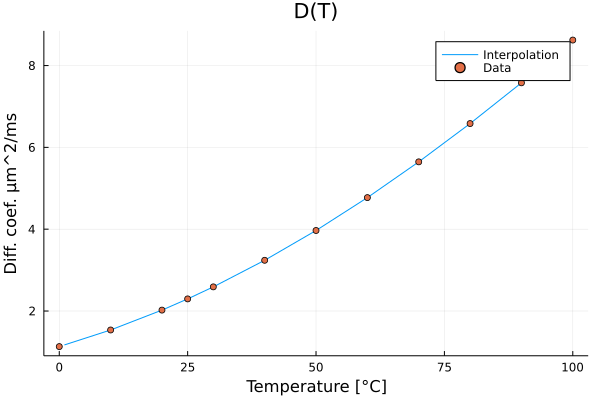

In [9]:
# https://dtrx.de/od/diff/
T_diff = D_df[:, 1]
D_diff = D_df[:, 3]
itpD = LinearInterpolation(T_diff, D_diff); # μm^2/ms
plot(1:100, itpD.(1:100), label="Interpolation", title="D(T)", xaxis="Temperature [°C]", yaxis="Diff. coef. μm^2/ms")
scatter!(T_diff, D_diff, label="Data")

### Maximum solubility of sugar in water Cs(T)

In [15]:
# https://chestofbooks.com/food/science/Experimental-Cookery/The-Solubility-Of-The-Sugars.html
Cs_df =  CSV.read("sugar_solubility.csv", DataFrame)
first(Cs_df, 3)

,TempC,"Grams of sucrose in 100 grams of solution, or per cent",Grams of sucrose dissolved by 100 grams of water
,Int64,Float64,Float64
1,0,64.18,179.2
2,5,64.87,184.7
3,10,65.58,190.5


In [18]:
names(Cs_df)

4-element Vector{String}:
 "TempC"
 "Grams of sucrose in 100 grams of solution, or per cent"
 "Grams of sucrose dissolved by 100 grams of water"
 "Specific gravity of solution"

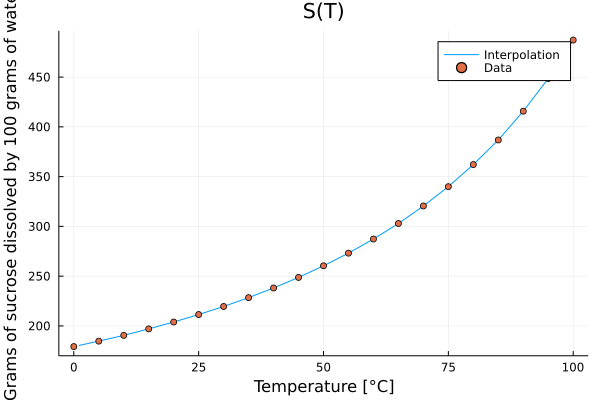

In [20]:
T_solubility = Cs_df[:, 1]
S_solubility = Cs_df[:, 3]
itp_solubility = LinearInterpolation(T_solubility, S_solubility); # μm^2/ms
plot(1:100, itp_solubility.(1:100), label="Interpolation", title="S(T)", xaxis="Temperature [°C]", yaxis="Grams of sucrose dissolved by 100 grams of water")
scatter!(T_solubility, S_solubility, label="Data")

In [ ]:
# http://jwilson.coe.uga.edu/EMAT6680Fa2014/Gieseking/Exploration%2012/Newton's%20Law%20of%20Cooling.htm

### Current sugar concentration C_b(m)

In [21]:
Cb(m) = (m0 - m) / (V_w + V_m)

Cb (generic function with 1 method)

### Surface area of sugar A(m)

In [25]:
A(m) = m # TODO

A (generic function with 1 method)

### Interface width d

In [27]:
d = 1 # TODO

1

### Dynamics

In [28]:
dmdt(m, T) = A(m) * D(T) / d * (Cs(T) - Cb(m))

dmdt (generic function with 1 method)

### Cooling constant k

This one is the hardest to estimate.
Cooling heavily depends on cup shape and volume.
Right now I assumed we will use [Newton's cooling law](https://en.wikipedia.org/wiki/Newton%27s_law_of_cooling).
We might consider simulating the whole cup thermal dynamics without Newton's approximation.

However, here are some places with calculations of constant $k$:

- http://jwilson.coe.uga.edu/EMAT6680Fa2014/Gieseking/Exploration%2012/Newton's%20Law%20of%20Cooling.htm
- https://www.carolina.com/teacher-resources/Interactive/newtons-law-of-cooling/tr36401.tr
- https://www.ukessays.com/essays/mathematics/equation-to-model-a-cooling-cup-of-coffee.php

Since we want to have $V_m$ and $V_w$ as simulation variables, we need some kind of $k(V_m, V_w)$ function.